In [2]:
class Node:
    def __init__(self, item, twu, tf=1, parent=None):
        self.item = item
        self.twu = twu
        self.tf = tf
        self.parent = parent
        self.children = {}
        self.node_link = None
    
    
    def increment_vals(self, twu, tf=1):
        self.twu += twu
        self.tf += tf


    # Draws node with twu and tf vals, for debugging
    def draw_node(self, indent=1):
        print('     ') * indent + f"{self.item}: twu={self.twu}, tf={self.tf}"
        for child in self.children.values():
            child.draw_nodes(indent + 1)

In [3]:
class IHUPTree:
    def __init__(self):
        self.root = Node(item=None, twu=0, tf=0)
        self.header_table = {}


    def update_header(self, node):
        # If item/node has been seen
        if node.item in self.header_table:
            # Traverse linked list of nodes referencing that item
            current = self.header_table[node.item]
            while current.node_link is not None:
                current = current.node_link
            # Add item/node to end of list
            current.node_link = node
        # If item/node has not been seen
        else:
            # Add entry to the table
            self.header_table[node.item] = node


    def insert_transaction(self, transaction, transaction_utility):
        current_node = self.root
        for item in transaction:
            # If the item has already been seen
            if item in current_node.children:
                # Extract the node object
                child = current_node.children[item]
                # Increment the twu by the transaction utility and the freq by one
                child.increment_vals(transaction_utility)
            # If time hasn't been seen
            else:
                # Create new child object
                child = Node(item=item, twu=transaction_utility, parent=current_node)
                # Add the item's node to the current's children
                current_node.children[item] = child
                # Add entry to the table
                self.update_header(child)
            # Traverse through transaction
            current_node = child

    # Draw tree for debugging
    def draw_tree(self):
        for child in self.root.children.values():
            child.draw_node(indent=1)

In [13]:
def get_candidates(tree, minutil, prefix, candidates):
    #print(f"get_candidates called with prefix: {prefix}")
    for item in sorted(tree.header_table.keys()):
        # Create a new candidate by appending the item to the partial itemset made so far
        new_candidate = prefix + [item]
        
        # Sum the utilties
        utility = 0
        # Traverse the list of all appearances of the item in tree
        current = tree.header_table[item]
        while current is not None:
            utility += current.twu
            current = current.node_link

            #print(f"Candidate {new_candidate} has aggregated TWU: {utility}")

        if utility >= minutil:
            candidates[tuple(new_candidate)] = utility

        proj_tree = get_projected_tree(tree, item)
        # If the tree not empty
        if proj_tree.root.children:
            # Recurse
            #print(f"Recursing on projected tree for candidate {new_candidate}")
            get_candidates(proj_tree, minutil, new_candidate, candidates)


def get_projected_tree(full_tree, item):
    proj_tree = IHUPTree()
    if item not in full_tree.header_table:
        return proj_tree
    
    current = full_tree.header_table[item]
    while current is not None:
        prefix_path = get_prefix_path(current)
        if prefix_path:
            proj_tree.insert_transaction(prefix_path, current.twu)
        current = current.node_link
    return proj_tree


def get_prefix_path(node):
    path = []
    current = node.parent
    while current is not None and current.item is not None:
        path.insert(0, current.item)
        current = current.parent
    return path


def exact_high_utilities(candidates, transactions, minutil):
    candidate_utilities = {candidate: 0 for candidate in candidates}
    
    # Stream through the file transaction by transaction
    trans_count = 0
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue  # Skip empty lines
            
            trans_count += 1
            #if trans_count % 5000 == 0:
                #print(f"Processed {trans_count} transactions for exact utility computation")

            # Parse the transaction line.
            parts = line.strip().split(':')
            trans_items = parts[0].strip().split()
            # The second part (total utility) is not used for exact utility computation.
            item_utils = [float(x) for x in parts[2].strip().split()]
            
            # Build a map of item to its individual utility in this transaction.
            util_map = {item: util for item, util in zip(trans_items, item_utils)}
            trans_item_set = set(trans_items)
            
            # For each candidate, update its utility if it appears in the current transaction.
            for candidate in candidate_utilities:
                candidate_set = set(candidate)
                if candidate_set.issubset(trans_item_set):
                    # Sum the individual utilities for the items in the candidate from this transaction.
                    candidate_util = sum(util_map[item] for item in candidate)
                    candidate_utilities[candidate] += candidate_util

    print("Finished processing transactions for exact utilities.")
       
    # Filter out candidates whose exact utility is below the minutil threshold.
    hui = {candidate: utility for candidate, utility in candidate_utilities.items() if utility >= minutil}
    
    print(f"Number of high utility candidates: {len(hui)}")

    return hui


def get_high_utility_itemsets(file_path, minutil):
    # Build the initial tree by streaming through the file.
    print("Starting to build IHUPTree from transactions...")

    tree = IHUPTree()
    trans_count = 0
    item_utilities_sum = {}
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue

            trans_count += 1

            parts = line.strip().split(':')
            items = parts[0].strip().split()
            total_util = float(parts[1].strip())

            item_utils = [float(x) for x in parts[2].strip().split()]
            for item, utility in zip(items, item_utils):
                item_utilities_sum[item] = item_utilities_sum.get(item, 0) + utility

            # We use only items and total_util to build the tree.
            tree.insert_transaction(items, total_util)
            #if trans_count % 5000 == 0:
                #print(f"Inserted {trans_count} transactions into the tree")

    
    print(f"Finished building tree with {trans_count} transactions.")

    #total_individual_utility = sum(item_utilities_sum.values())
    #print(f"Total individual utility: {total_individual_utility}")

    print("Starting candidate generation...")
    # Generate candidates from the tree.
    candidates = {}
    get_candidates(tree, minutil, prefix=[], candidates=candidates)


    print("Candidate generation finished.")
    print(f"Total candidates generated: {len(candidates)}")
    # Compute the exact utility of each candidate via file streaming.
    high_utility_itemsets = exact_high_utilities(candidates, file_path, minutil)

    print("Exact utility computation finished.")
    return high_utility_itemsets

In [14]:
import os

def write_results_to_file(results, input_file, minutil, output_folder="../output"):
    # Create the output folder if it doesn't exist.
    os.makedirs(output_folder, exist_ok=True)
    
    # Extract the base name without extension.
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    # Build the output file name.
    output_filename = f"{base_name}_high_utility_itemsets_min{minutil}.txt"
    output_path = os.path.join(output_folder, output_filename)
    
    with open(output_path, "w") as file:
        for itemset, utility in results.items():
            # Convert the tuple candidate to a string using a space separator.
            itemset_str = ' '.join(itemset)
            file.write(f"{itemset_str} {utility}\n")
    
    print(f"Results have been written to: {output_path}")


In [ ]:
# Singular Test

input_dir = "../data/"
input_file = "Chicago_Crimes_2001_to_2017_utility.txt"
file_path = input_dir + input_file
minutil = 7941

high_utility_itemsets = get_high_utility_itemsets(file_path, minutil)

write_results_to_file(high_utility_itemsets, input_file, minutil)


Total dataset utility: 7941285.0
Running algorithm with min utility = 79412.85 (i.e. 1.0%)...
Starting to build IHUPTree from transactions...
Finished building tree with 2662309 transactions.
Starting candidate generation...
Candidate generation finished.
Total candidates generated: 354
Finished processing transactions for exact utilities.
Number of high utility candidates: 183
Exact utility computation finished.
Threshold 1.0%: runtime = 125.34 seconds, 183 high utility itemsets found.
Running algorithm with min utility = 79412.85 (i.e. 1.0%)...
Starting to build IHUPTree from transactions...
Finished building tree with 2662309 transactions.
Starting candidate generation...
Candidate generation finished.
Total candidates generated: 354
Finished processing transactions for exact utilities.
Number of high utility candidates: 183
Exact utility computation finished.
Threshold 1.0%: runtime = 121.03 seconds, 183 high utility itemsets found.
Running algorithm with min utility = 158825.7 (i.

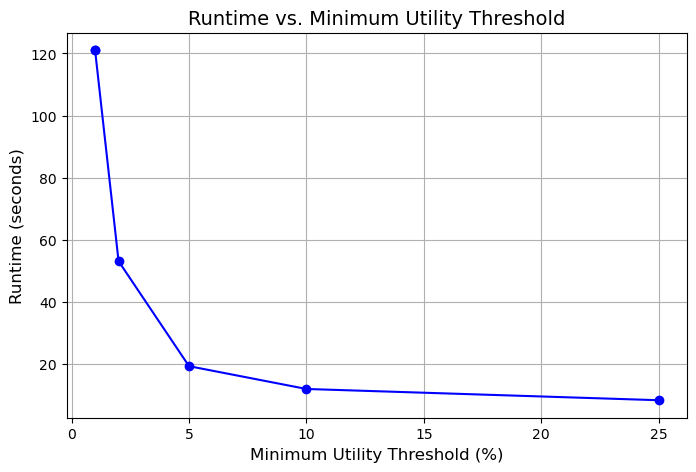

In [ ]:
import time
import os

import matplotlib.pyplot as plt


def compute_total_dataset_utility(file_path):
    """Compute the sum of all transaction total utilities (i.e., dataset total utility)."""
    total_util = 0.0
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(':')
            total_util += float(parts[1].strip())
    return total_util

# Path to your dataset
input_dir = "../data/"
input_file = "Chicago_Crimes_2001_to_2017_utility.txt"
file_path = os.path.join(input_dir, input_file)

# Compute the dataset's total utility.
total_dataset_utility = compute_total_dataset_utility(file_path)
print(f"Total dataset utility: {total_dataset_utility}")

# List of percentage thresholds (expressed as decimals: 0.01 = 1%, 0.05 = 5%, etc.)
threshold_percentages = [0.01, 0.02, 0.05, 0.10, 0.25]

# Dictionary to store runtimes keyed by percentage threshold.
runtimes = {}

for pct in threshold_percentages:
    # Convert percentage to an absolute minimum utility.
    min_util = total_dataset_utility * pct
    print(f"Running algorithm with min utility = {min_util} (i.e. {pct*100}%)...")
    
    start_time = time.time()
    # Run the mining algorithm.
    high_utility_itemsets = get_high_utility_itemsets(file_path, min_util)
    elapsed = time.time() - start_time
    
    runtimes[pct] = elapsed
    print(f"Threshold {pct*100}%: runtime = {elapsed:.2f} seconds, {len(high_utility_itemsets)} high utility itemsets found.")

# After running, print a summary:
print("\nRuntime Summary:")
for pct, runtime in runtimes.items():
    print(f"{pct*100}% threshold | runtime: {runtime:.2f} seconds")


x = [pct * 100 for pct in threshold_percentages]
y = [runtimes[pct] for pct in threshold_percentages]

# --- Plotting the candidates generated vs. the minimum utility threshold percentage ---
# Convert thresholds to percentage values for x-axis labels
x_candidates = [pct * 100 for pct in threshold_percentages]
y_candidates = [354, 354, 148, 40, 16, 4]

# Create a figure with two subplots (side by side).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot runtime vs. threshold on the first subplot.
ax1.plot(x, y, marker='o', linestyle='-', color='blue')
ax1.set_xlabel("Minimum Utility Threshold (%)", fontsize=12)
ax1.set_ylabel("Runtime (seconds)", fontsize=12)
ax1.set_title("Runtime vs. Minimum Utility Threshold", fontsize=14)
ax1.grid(True)

# Plot candidate counts vs. threshold on the second subplot.
ax2.plot(x_candidates, y_candidates, marker='o', linestyle='-', color='green')
ax2.set_xlabel("Minimum Utility Threshold (%)", fontsize=12)
ax2.set_ylabel("Candidates", fontsize=12)
ax2.set_title("Candidates vs. Minimum Utility Threshold", fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()